<a href="https://colab.research.google.com/github/Hassan2711/GenAI_assignment2/blob/main/GANs_GenAi_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Set Up the Environment

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

checkpoint_dir = "/content/drive/MyDrive/PGGAN_Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "progressive_gan_checkpoint.pth")


Mounted at /content/drive


In [3]:
!pip install torch torchvision tqdm numpy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader


# Step 2: Download and Prepare the Anime Face Dataset


## 2.1 Download Dataset


In [4]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d splcher/animefacedataset

!unzip animefacedataset.zip -d anime_faces


Streaming output truncated to the last 5000 lines.
  inflating: anime_faces/images/62764_2019.jpg  
  inflating: anime_faces/images/62765_2019.jpg  
  inflating: anime_faces/images/62766_2019.jpg  
  inflating: anime_faces/images/62767_2019.jpg  
  inflating: anime_faces/images/62768_2019.jpg  
  inflating: anime_faces/images/62769_2019.jpg  
  inflating: anime_faces/images/6276_2003.jpg  
  inflating: anime_faces/images/62770_2019.jpg  
  inflating: anime_faces/images/62771_2019.jpg  
  inflating: anime_faces/images/62772_2019.jpg  
  inflating: anime_faces/images/62773_2019.jpg  
  inflating: anime_faces/images/62774_2019.jpg  
  inflating: anime_faces/images/62775_2019.jpg  
  inflating: anime_faces/images/62776_2019.jpg  
  inflating: anime_faces/images/62777_2019.jpg  
  inflating: anime_faces/images/62778_2019.jpg  
  inflating: anime_faces/images/62779_2019.jpg  
  inflating: anime_faces/images/6277_2003.jpg  
  inflating: anime_faces/images/62780_2019.jpg  
  inflating: anime_f

## 2.2 Preprocess the Dataset

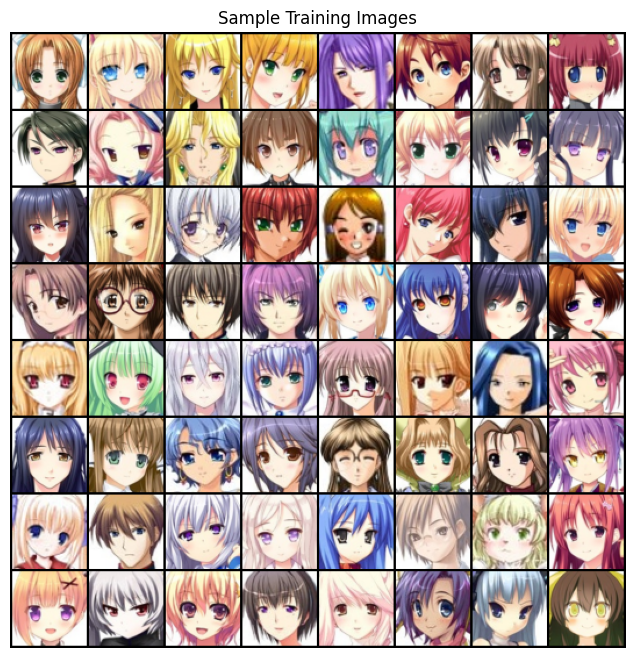

In [5]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


dataset = torchvision.datasets.ImageFolder(root="anime_faces", transform=transform)

batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()


# Step 3: Define the DCGAN Model

## 3.1 Define the Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


## 3.2 Define the Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


# Step 4: Define Loss Function and Optimizer

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
lr = 0.00015
beta1 = 0.5

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


# Step 5: Load Checkpoint (if available)

In [9]:

start_epoch = 0
if os.path.isfile(checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        generator.load_state_dict(checkpoint['generator_state_dict'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ Resuming from epoch {start_epoch}")
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        print("🗑️ Deleting corrupted checkpoint and starting fresh.")
        # os.remove(checkpoint_path)
else :

        print(f"no path")


✅ Resuming from epoch 71


# Step 6: Train the GAN

Epoch 72/100 | Loss D: 0.7631 | Loss G: 1.3050
✅ Checkpoint saved at epoch 71
Epoch 73/100 | Loss D: 0.5503 | Loss G: 2.6892
✅ Checkpoint saved at epoch 72


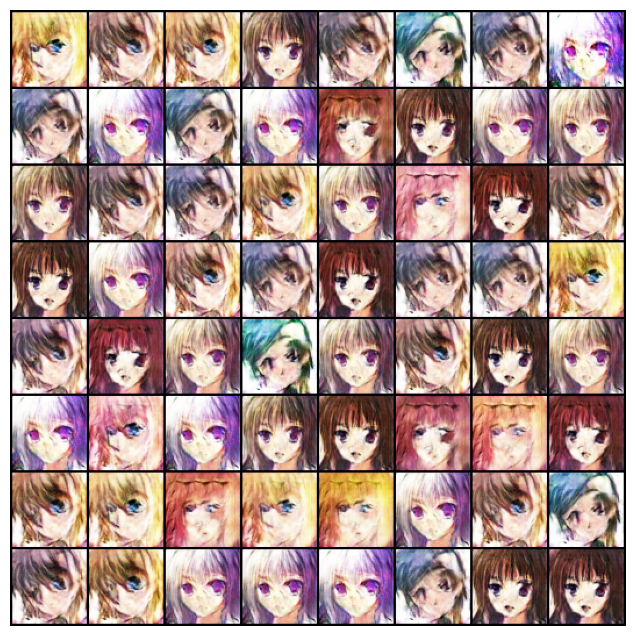

Epoch 74/100 | Loss D: 0.7480 | Loss G: 1.4761
✅ Checkpoint saved at epoch 73
Epoch 75/100 | Loss D: 0.6890 | Loss G: 1.5728
✅ Checkpoint saved at epoch 74


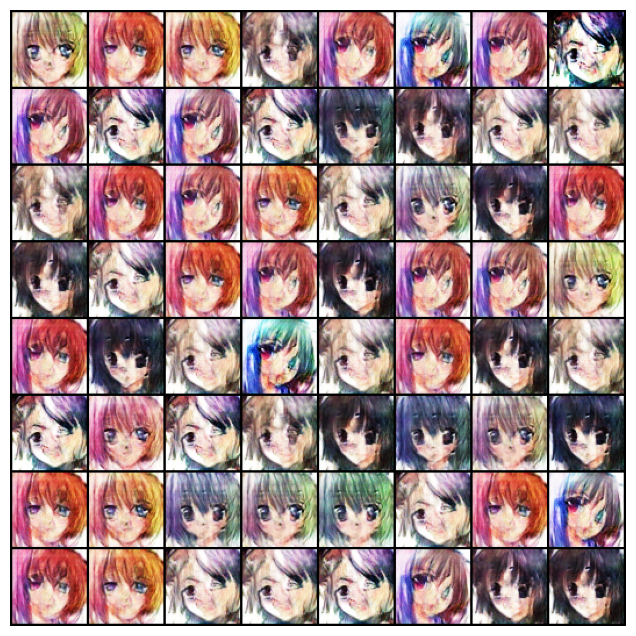

KeyboardInterrupt: 

In [12]:
epochs = 100
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

for epoch in range(start_epoch, epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        real_images += 0.05 * torch.randn_like(real_images)


        real_labels = torch.full((batch_size, 1, 1, 1), 0.85, device=device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1, device=device)

        optimizer_D.zero_grad()
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, real_labels)

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(z)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        output_fake = discriminator(fake_images)
        loss_G = criterion(output_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

    temp_checkpoint_path = checkpoint_path + ".tmp"
    torch.save({
        'epoch': epoch,
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_state_dict': generator.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
    }, temp_checkpoint_path)

    os.fsync(os.open(temp_checkpoint_path, os.O_RDONLY))
    os.rename(temp_checkpoint_path, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}")

    if epoch % 2 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(fake_images[:64], padding=2, normalize=True), (1, 2, 0)))
        plt.show()




# Step 7: Saving

In [13]:
from google.colab import files

torch.save(generator.state_dict(), 'progressive_gan_generator.pth')
torch.save(discriminator.state_dict(), 'progressive_gan_discriminator.pth')

torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
}, 'progressive_gan_model.pth')

!cp progressive_gan_generator.pth "/content/drive/MyDrive/PGGAN_Checkpoints/"
!cp progressive_gan_discriminator.pth "/content/drive/MyDrive/PGGAN_Checkpoints/"
!cp progressive_gan_model.pth "/content/drive/MyDrive/PGGAN_Checkpoints/"

files.download("progressive_gan_generator.pth")
files.download("progressive_gan_discriminator.pth")
files.download("progressive_gan_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>